# NLP Topic Modeling: Obama VS Trump (Round III)

**NLP Pipeline:**
- Data preprocessing with spacy.
- Bag of Words with gensim.
- LDA with gensim.

https://towardsdatascience.com/building-a-topic-modeling-pipeline-with-spacy-and-gensim-c5dc03ffc619

https://medium.com/@colemiller94/topic-modeling-with-spacy-and-gensim-7ecfd3de95f4

https://www.kaggle.com/thebrownviking20/topic-modelling-with-spacy-and-scikit-learn

### Import packages

In [1]:
# ! python -m spacy download en_core_web_lg
# ! python -m spacy download en_core_web_sm

In [2]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

import numpy as np
import pandas as pd
import re

# pprint is to make our topics formatted a little nicer when we take a look.
from pprint import pprint

# tqdm is a module that allows you to create progress bars to track how long your code is
# taking to process.
from tqdm.notebook import tqdm 
# from tqdm import tqdm_notebook as tqdm # deprecated

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import pyLDAvis
from pyLDAvis import gensim

unable to import 'smart_open.gcs', disabling that module


### Import data

In [3]:
# https://www.kaggle.com/austinreese/trump-tweets
df_trump = pd.read_csv('./datasets/trump_tweets.csv')
# https://www.kaggle.com/datacrux/barack-obama-twitterdata-from-20122019
df_obama = pd.read_csv('./datasets/obama_tweets.csv')

### Explore data

In [4]:
df_trump.head(1)

,id,link,content,date,retweets,favorites,mentions,hashtags,geo
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,NaN,NaN,NaN


In [5]:
df_obama.head(1)

,Date,Username,Tweet-text,Tweet Link,Retweets,Likes,TweetImageUrl,Image
0,2019/04/10_17:08,https://twitter.com/BarackObama,From a big NBA fan congrats to future Hall of ...,https://twitter.com/BarackObama/status/1116130...,20954,175133,NaN,NaN


### Data preprocessing

#### Deleting links

In [6]:
# pic.twitter.com
df_trump['content'] = df_trump['content'].map(lambda x: re.sub(r'pic.twitter.com/\w\w\w\w\w\w\w\w\w\w', '', x))
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub(r'pic.twitter.com/\w\w\w\w\w\w\w\w\w\w', '', x))

In [7]:
# tinyurl
df_trump['content'] = df_trump['content'].map(lambda x: re.sub(r'http://tinyurl.com/\w\w\w\w\w\w', '', x))
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub(r'http://tinyurl.com/\w\w\w\w\w\w', '', x))

In [8]:
# bit.ly
df_trump['content'] = df_trump['content'].map(lambda x: re.sub(r'http://bit.ly/\w\w\w\w\w\w', '', x))
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub(r'http://bit.ly/\w\w\w\w\w\w', '', x))

In [9]:
# Others:
df_trump['content'] = df_trump['content'].map(lambda x: re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x))
df_obama['Tweet-text'] = df_obama['Tweet-text'].map(lambda x: re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x))

### Spacy Pipeline:

The first step in natural language processing is really preprocessing. Generally, we want to reduce our raw text to a list of ‘important words’. This process is called tokenization, and spaCy is a great tool to accomplish this.

#### Now for the fun part - we’ll build the pipeline! The default spaCy pipeline is laid out like this:

- Tokenizer: Breaks the full text into individual tokens.
- Tagger: Tags each token with the part of speech.
- Parser: Parses into noun chunks, amongst other things.
- Named Entity Recognizer (NER): Labels named entities, like U.S.A.

spaCy has a robust stop words list and lemmatizer built in, but we’ll need to add that functionality into the pipeline.

In [10]:
nlp = spacy.load('en_core_web_sm')

#### Stop words:

They are basically common words that don’t really add a lot of predictive value to your model. If you don’t remove the word “the” from your corpus for example, it will likely show up in every topic you generate, given how often “the” is used in the English language.

We can add words in to spaCy’s default stop words list like so:

In [11]:
# My list of stop words
stop_list = ["president", "donald", "trump", "barack", "obama", "'s"]
# spaCy is smart enough to break some contractions into their component words when lemmatized
# (like “isn’t” into “is” and “not”), but that’s not the case for “‘s”. So that’ll need to go
# as well.

# Updates spaCy's default stop words list with my additional words. 
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

In [12]:
print(list(STOP_WORDS)[0:10])

['of', 'hereupon', 'amount', 'seems', 'quite', 'another', 'already', 'name', 'will', 'together']


#### Named Entity Recognizer (NER):

In [19]:
documento_prueba_trump = nlp(df_trump['content'][0].lower())
spacy.displacy.render(documento_prueba_trump, style='ent',jupyter=True)

In [21]:
documento_prueba_obama = nlp(df_obama['Tweet-text'][1].lower())
spacy.displacy.render(documento_prueba_obama, style='ent',jupyter=True)

#### Adding lemmatizer & remove_stopwords to the pipeline:

We’ll also need to **lemmatize** the texts, which is simply reducing each word to it’s root. So for example, “going” and “goes” both are reduced to “go”. “Better” would be reduced to “good”.

Ok, so now **let’s build out our pipeline**, adding functions for both lemmatization and stop word removal:

In [13]:
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them.
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

The important thing here is to make sure you’re returning token.text for your final output. That will turn each token object into a string object, so it can be used in Gensim.

#### Let's run the pipeline!

(For Gensim, I’m ultimately going to need to create a list of lists)

In [ ]:
# Trump
doc_list_trump = []
# Iterates through each article in the corpus.
for doc in tqdm(df_trump['content']):
    # print(doc)
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc.lower()) # Añado .lower() para que pase todas las palabras a minúscula.
    # print(pr)
    doc_list_trump.append(pr)
    
# Obama
doc_list_obama = []
# Iterates through each article in the corpus.
for doc in tqdm(df_obama['Tweet-text']):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc.lower()) # Añado .lower() para que pase todas las palabras a minúscula.
    doc_list_obama.append(pr)

Here’s what one of those tweets now looks like after having gone through the pipeline:

In [13]:
doc_list_trump[0]

['sure',
 'tune',
 'watch',
 'late',
 'night',
 'david',
 'letterman',
 'present',
 'list',
 'tonight']

In [14]:
doc_list_obama[0]

['big',
 'nba',
 'fan',
 'congrat',
 'future',
 'hall',
 'famers',
 'dwyane',
 'wade',
 'dirk',
 'nowitzki',
 'time',
 'great',
 'class',
 'act']

### Bag of Words

Now that we’ve processed the articles, we’ll need to create the inputs needed for our topic model:

In [15]:
# Creates a dictionary which is a mapping of word IDs to words.
words_trump = corpora.Dictionary(doc_list_trump)
words_obama = corpora.Dictionary(doc_list_obama)

# Turns each document into a bag of words.
corpus_trump = [words_trump.doc2bow(doc) for doc in doc_list_trump]
corpus_obama = [words_obama.doc2bow(doc) for doc in doc_list_obama]

### LDA

Finally we can run the model itself.

*The Model: There are many algorithms used for Topic Modeling. I ended up using a popular generative statistical model called ‘Latent Dirichlet Allocation’ (LDA). To implement the model, I used GenSim a python library for topic modeling. The GenSim’s LDA model has three required parameters: Corpus, Dictionary, Number of Topics.*

In [16]:
lda_model_trump = gensim.models.ldamodel.LdaModel(corpus=corpus_trump, id2word=words_trump,
                                                  num_topics=10, random_state=2, 
                                                  update_every=1, passes=10,
                                                  alpha='auto', per_word_topics=True)

In [17]:
lda_model_obama = gensim.models.ldamodel.LdaModel(corpus=corpus_obama, id2word=words_obama,
                                                  num_topics=10, random_state=2, 
                                                  update_every=1, passes=10,
                                                  alpha='auto', per_word_topics=True)

And finally, some sample topics (note the pprint to help with formatting):

In [18]:
# Print keywords in the 10 topics:
pprint(lda_model_trump.print_topics(num_words=10))
# lda_model_trump.show_topics(num_words=10)

[(0,
  '0.033*"allow" + 0.028*"tariff" + 0.024*"transcript" + 0.023*"release" + '
  '0.021*"live" + 0.014*"treat" + 0.014*"miss" + 0.014*"angry" + '
  '0.013*"evidence" + 0.012*"louisiana"'),
 (1,
  '0.056*"new" + 0.050*"news" + 0.044*"fake" + 0.027*"state" + 0.021*"poll" + '
  '0.021*"report" + 0.017*"security" + 0.016*"totally" + 0.016*"cnn" + '
  '0.014*"mexico"'),
 (2,
  '0.049*"work" + 0.025*"wall" + 0.022*"happen" + 0.022*"hard" + '
  '0.017*"congratulation" + 0.016*"leave" + 0.016*"fbi" + 0.016*"hoax" + '
  '0.016*"meeting" + 0.015*"national"'),
 (3,
  '0.083*"great" + 0.043*"thank" + 0.037*"realdonaldtrump" + 0.027*"good" + '
  '0.023*"job" + 0.021*"america" + 0.020*"vote" + 0.019*"win" + 0.018*"  " + '
  '0.016*"look"'),
 (4,
  '0.047*"thing" + 0.044*"medium" + 0.042*"democrat" + 0.030*"end" + '
  '0.028*"true" + 0.020*"immigration" + 0.020*"wow" + 0.019*"washington" + '
  '0.016*"crazy" + 0.016*"carolina"'),
 (5,
  '0.029*"china" + 0.028*"republican" + 0.023*"high" + 0.022*"t

In [19]:
pprint(lda_model_obama.print_topics(num_words=10))

[(0,
  '0.074*"  " + 0.053*"change" + 0.039*"@ofa" + 0.036*"climate" + '
  '0.028*"fight" + 0.028*"actonclimate" + 0.023*"\xa0  " + 0.019*"action" + '
  '0.017*"hear" + 0.016*"join"'),
 (1,
  '0.054*"congress" + 0.052*"gun" + 0.048*"violence" + 0.025*"reduce" + '
  '0.021*"act" + 0.020*"right" + 0.019*"  " + 0.017*"thing" + 0.016*"people" + '
  '0.015*"tell"'),
 (2,
  '0.039*"immigration" + 0.034*"  " + 0.026*"reform" + 0.021*"work" + '
  '0.017*"system" + 0.016*"let" + 0.016*"today" + 0.015*"chance" + '
  '0.015*"family" + 0.013*"come"'),
 (3,
  '0.066*"  " + 0.021*"watch" + 0.021*"address" + 0.019*"economy" + '
  '0.018*"america" + 0.016*"work" + 0.015*"house" + 0.013*"sotu" + '
  '0.013*"weekly" + 0.011*"american"'),
 (4,
  '0.045*"  " + 0.043*"health" + 0.034*"care" + 0.025*"million" + 0.025*"\xa0  '
  '" + 0.024*"americans" + 0.021*"obamacare" + 0.020*"insurance" + 0.014*"$" + '
  '0.014*"affordable"'),
 (5,
  '0.050*"  " + 0.027*"job" + 0.016*"happen" + 0.014*"month" + '
  '0.014

### WordClouds

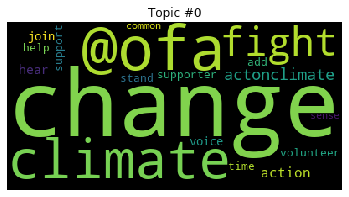

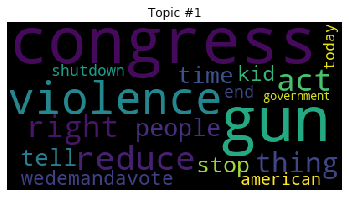

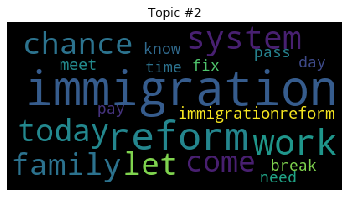

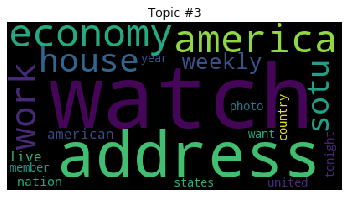

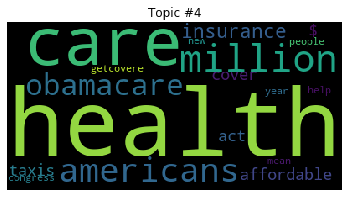

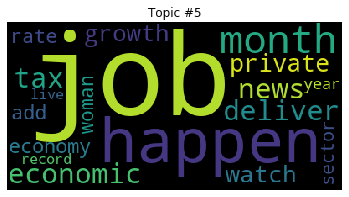

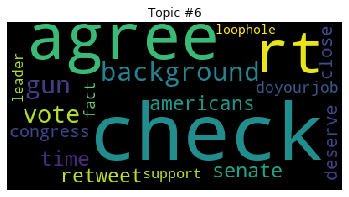

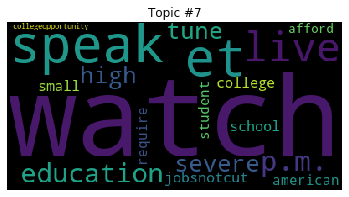

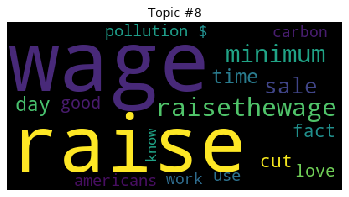

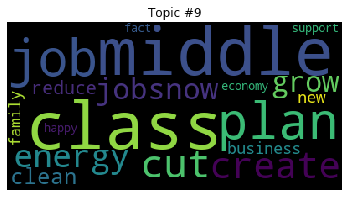

In [26]:
for topic in range(lda_model_obama.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color="black",
               max_words=20).fit_words(dict(lda_model_obama.show_topic(topic, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(topic))
    plt.show()

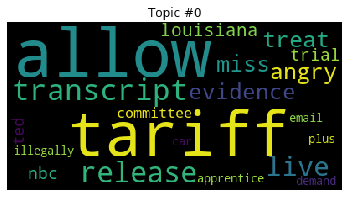

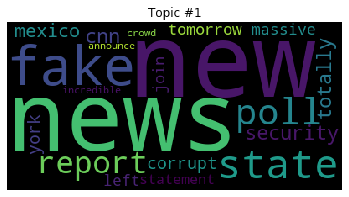

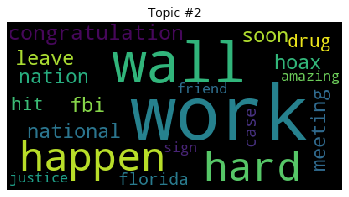

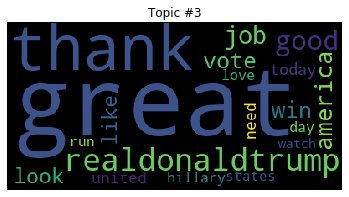

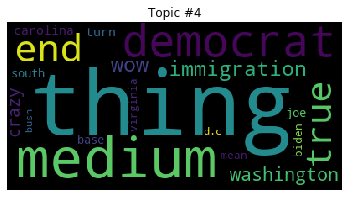

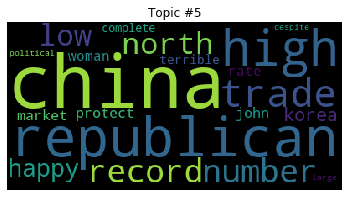

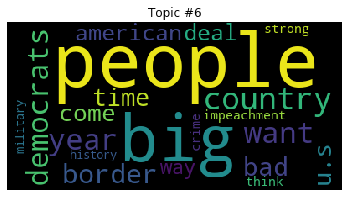

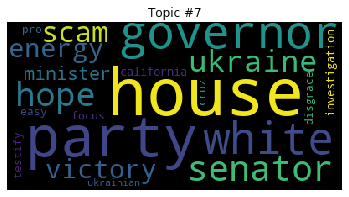

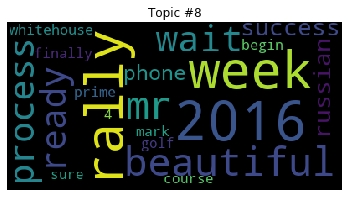

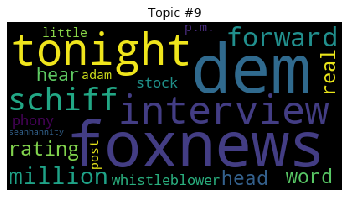

In [27]:
for topic in range(lda_model_trump.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color="black",
               max_words=20).fit_words(dict(lda_model_trump.show_topic(topic, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(topic))
    plt.show()

### pyLDAvis

This output shows our 10 topics and the marginal probability of a document being binned to each topic given the presence of a particular word. This is a great start to understanding our model, but we can do much better with visualization courtesy of pyLDAvis.

In [ ]:
pyLDAvis.enable_notebook()
gensim.prepare(lda_model_trump, corpus_trump, words_trump)

In [ ]:
pyLDAvis.enable_notebook()
gensim.prepare(lda_model_obama, corpus_obama, words_obama)

Naturally, there are a whole slew of hyperparameters you can pass as kwargs -> Good practice: Fitting different models to compare different settings -> Using pyLDAvis, comparing models is much easier.